This jupyter notebook aims to explain how to train and save a model Tensorflow. This one can be used to be upload as a new project on the user interface.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from tqdm import tqdm_notebook as tqdm
import random

import tensorflow as tf
import tensorflow.keras as keras



In [3]:
# function to generate the combination of all dimensions 

def gen_cube(instance):
    result = []
    for i in range(len(instance)):
        result.append([instance[(i+j)%len(instance)] for j in range(len(instance))])
    return result



### Step 1 :  Generate synthetic data replace this step with your data

In [4]:


import math
nb_instance = 200
def generate_ts(inf):
    ts = []
    if inf == 0:

        for i in range (0,8):
            sub = []
            for j in range (0,342):
                sub.append(math.sin(j/10))
            ts.append(sub)
    if inf == 1:
        for i in range (0,7):
            sub = []
            for j in range (0,342):
                sub.append(math.sin(j/10))
            ts.append(sub)
        ts.append([randint(0,10) for i in range(342)])  
    return ts


Class1 = [generate_ts(0) for j in range(nb_instance)]
Class2 = [generate_ts(1) for j in range(nb_instance)]

print('shape of Class1',np.array(Class1).shape)
print('shape of Class2',np.array(Class2).shape)

shape of Class1 (200, 8, 342)
shape of Class2 (200, 8, 342)


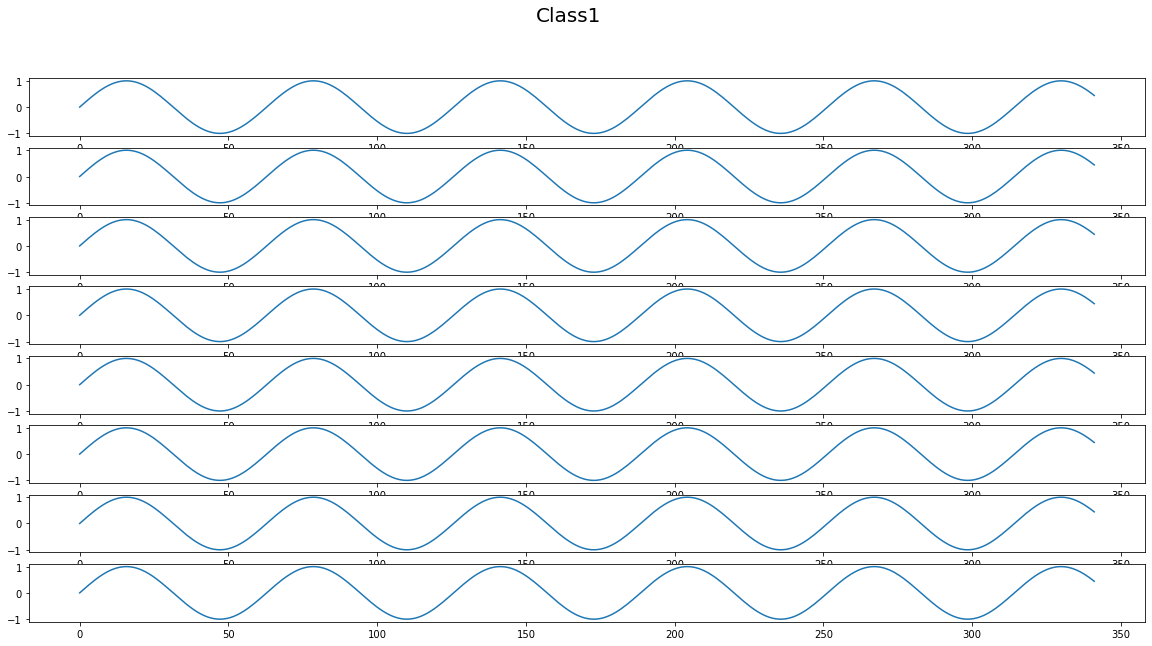

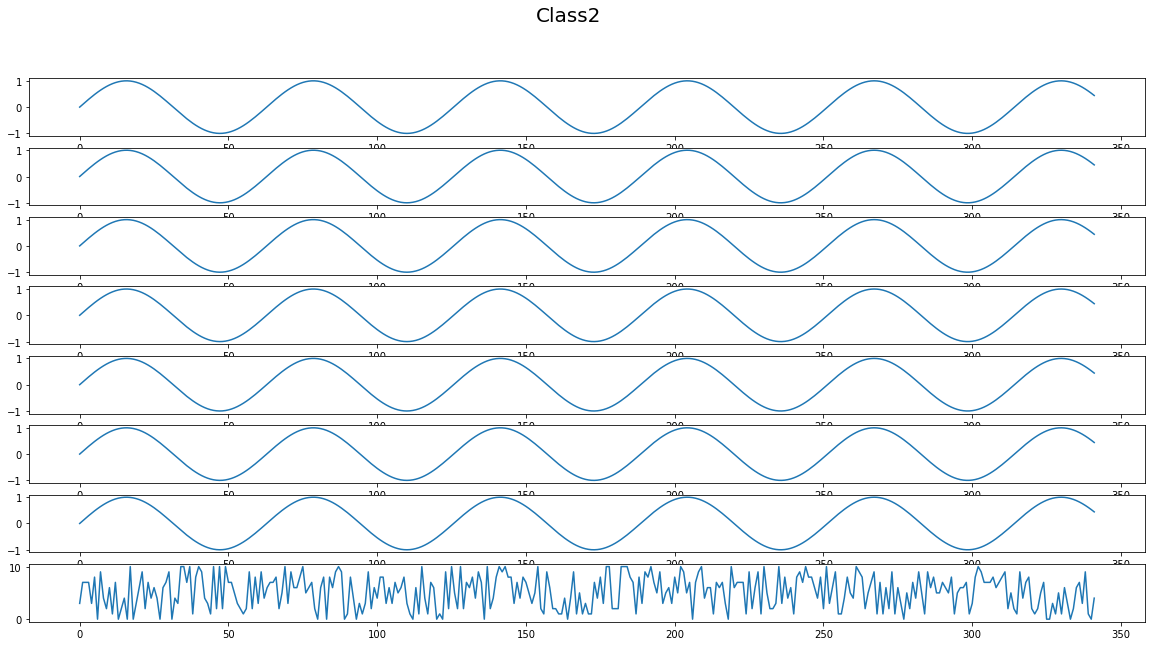

In [5]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Class1', fontsize=20)
for i in range(len(Class1[1])):
    plt.subplot(len(Class1[1]),1,1+i)
    plt.plot(Class1[7][i])
plt.show()
fig = plt.figure(figsize=(20,10))
fig.suptitle('Class2', fontsize=20)
for i in range(len(Class1[1])):
    plt.subplot(len(Class1[1]),1,1+i)
    plt.plot(Class2[7][i])
    
plt.show()


The following code is used to generate the data for the training and testing of the model. The data is generated by taking the combination of all the dimensions of the time series. The data is then split into training and testing data. The training data is then split into training and validation data.

In [6]:
label = [1]*100 + [0]*100
label_test = [1]*24 + [0]*24

label = np.array(label)
label_test = np.array(label_test)

all_class_1 = Class1[:100] + Class2[:100]
all_class_test_1 = Class1[100:124] + Class2[100:124]


all_class = np.array([gen_cube(acl) for acl in all_class_1])
all_class_test = np.array([gen_cube(acl) for acl in all_class_test_1])

X_train = all_class
y_train = label
X_test = all_class_test
y_test = label_test


In [7]:
def numpy_to_tf_input(numpy_input):
    """
    Converts a NumPy-style input array to a TensorFlow-style input array.
    
    Args:
        numpy_input (np.ndarray): Input array in NumPy format with shape [batch_size, channels, height, width].
        
    Returns:
        tf_input (np.ndarray): Input array in TensorFlow format with shape [batch_size, height, width, channels].
    """
    # Transpose the array to move the channel dimension to the last axis
    transposed_input = np.transpose(numpy_input, (0, 2, 3, 1))
    return transposed_input

In [8]:
def unison_shuffled_copies(a, b,c):
    assert len(a) == len(b)
    assert len(a) == len(c)
    
    p = np.random.permutation(len(a))
    return a[p], b[p],c[p]

X_train,y_train,all_class_shuffled = unison_shuffled_copies(X_train,y_train,np.array(all_class_1))
X_test,y_test,all_class_test_shuffled = unison_shuffled_copies(X_test,y_test,np.array(all_class_test_1))


In [9]:
X_train = numpy_to_tf_input(X_train)
X_test = numpy_to_tf_input(X_test)
X_train.shape,X_test.shape


((200, 8, 342, 8), (48, 8, 342, 8))

### Step 2 : Tune and train your model

In [10]:
def make_model(input_shape, n_filter_list=[16,16,32,32,64], kernel_size=(3,3), num_classes=2):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=n_filter_list[0], kernel_size=kernel_size, padding="same", input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    for iconv in range(1,len(n_filter_list)):
        if iconv==len(n_filter_list)-1:
            model.add(keras.layers.Conv2D(filters=n_filter_list[iconv], kernel_size=kernel_size, padding="same",name='last-conv'))
        else:
            model.add(keras.layers.Conv2D(filters=n_filter_list[iconv], kernel_size=kernel_size, padding="same"))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())
    
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    return model

In [11]:
model = make_model(input_shape=X_train.shape[1:], n_filter_list=[4,4,4,4,4], kernel_size=(1,3), num_classes=2)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 342, 4)         100       
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 342, 4)         16        
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 342, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 342, 4)         52        
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 342, 4)         16        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 342, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 342, 4)         5

In [12]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.00001), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
7/7 [==============================] - 5s 85ms/step - loss: 1.0570 - accuracy: 0.4300 - val_loss: 0.6689 - val_accuracy: 0.9375
Epoch 2/10
7/7 [==============================] - 0s 17ms/step - loss: 0.8764 - accuracy: 0.3250 - val_loss: 0.6581 - val_accuracy: 0.9375
Epoch 3/10
7/7 [==============================] - 0s 19ms/step - loss: 0.7820 - accuracy: 0.2650 - val_loss: 0.6458 - val_accuracy: 0.9583
Epoch 4/10
7/7 [==============================] - 0s 17ms/step - loss: 0.7067 - accuracy: 0.3300 - val_loss: 0.6328 - val_accuracy: 0.9792
Epoch 5/10
7/7 [==============================] - 0s 18ms/step - loss: 0.6263 - accuracy: 0.5200 - val_loss: 0.6208 - val_accuracy: 0.9792
Epoch 6/10
7/7 [==============================] - 0s 18ms/step - loss: 0.5594 - accuracy: 0.9050 - val_loss: 0.6072 - val_accuracy: 0.9792
Epoch 7/10
7/7 [==============================] - 0s 22ms/step - loss: 0.5013 - accuracy: 0.9250 - val_loss: 0.5978 - val_accuracy: 0.9792
Epoch 8/10
7/7 [===========

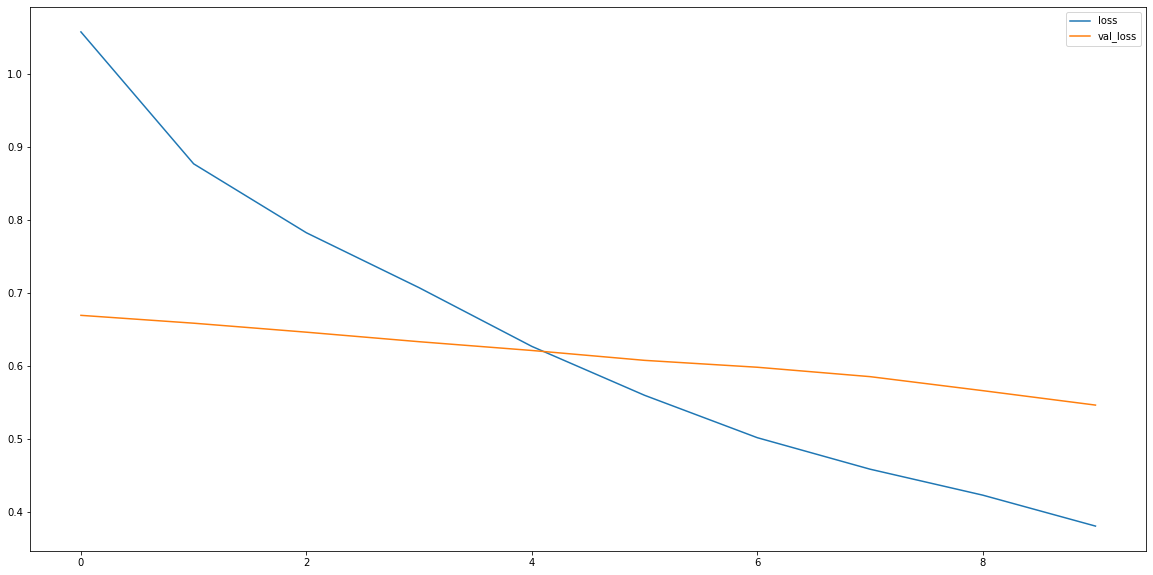

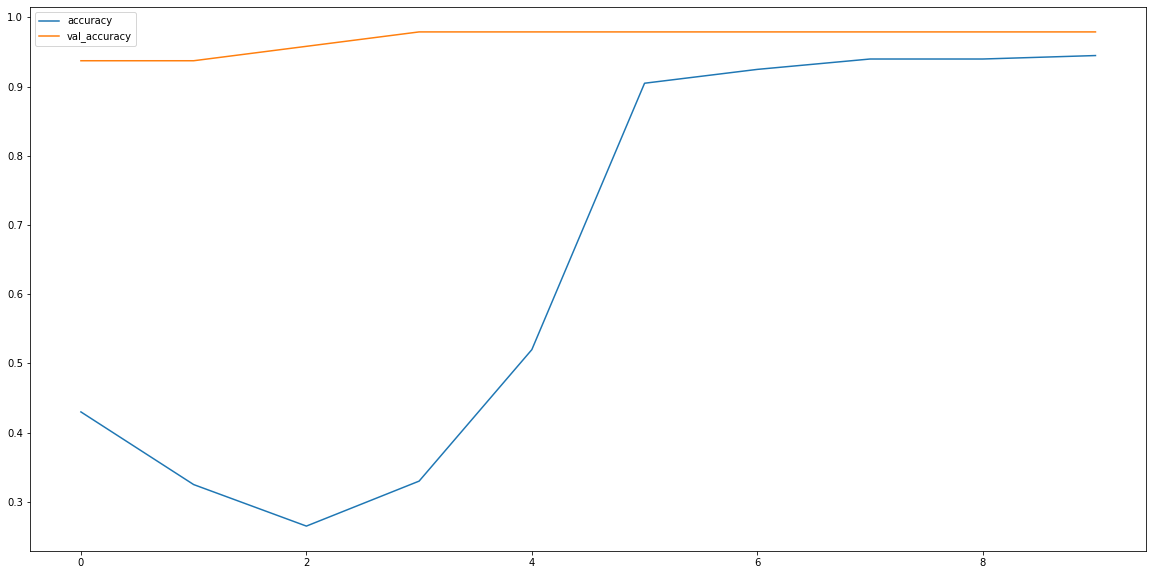

In [13]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()


### Step 4 : Save your model

In [14]:
name = "synthe"
model.save('saved_model/'+name)

INFO:tensorflow:Assets written to: saved_model/synthe\assets


### Step 5 : Generate the file used for dimensions name

In [15]:
dimensions_names = ['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8']

with open ('saved_model/'+name+'/config_file.txt','w') as f:
    f.write('dimensions_list:')
    for item in range(len(dimensions_names)):
        if item == len(dimensions_names)-1:
            f.write(dimensions_names[item])
        else:
            f.write(dimensions_names[item]+',')
        

### Step 6 : Generate std files


In [16]:
def get_std(dim,classe):
    all_row = []
    concat_x = np.concatenate((all_class_shuffled,all_class_test_shuffled))
    concat_y = np.concatenate((y_train,y_test))
    for i in range(len(concat_x)):
        if  concat_y[i] == classe:
            all_row.append(concat_x[i][dim])
    return np.std(all_row,axis=0), np.mean(all_row,axis=0)


all_classes_std_mean = []
for i in range(len(dimensions_names)):
    all_classes_std_mean.append(get_std(i,0))

all_classes_std_mean_1 = []
for i in range(len(dimensions_names)):
    all_classes_std_mean_1.append(get_std(i,1))

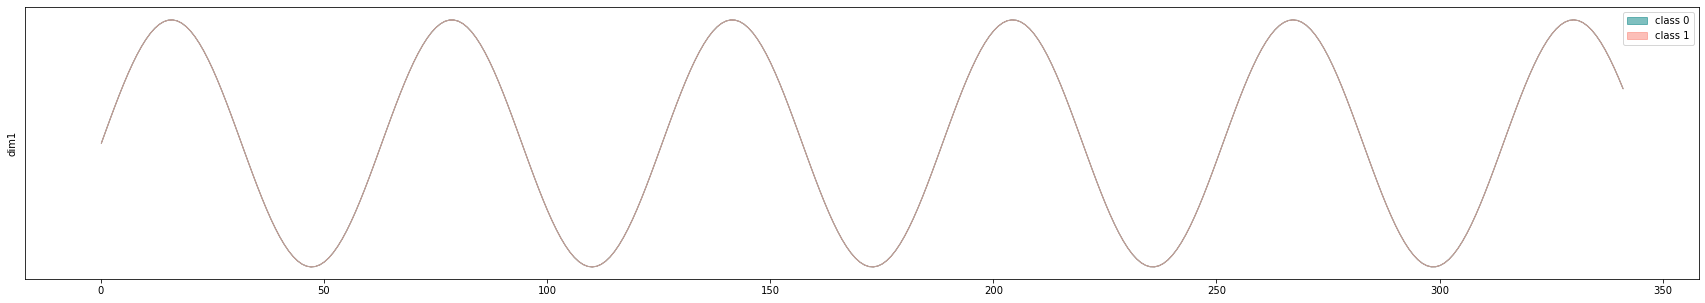

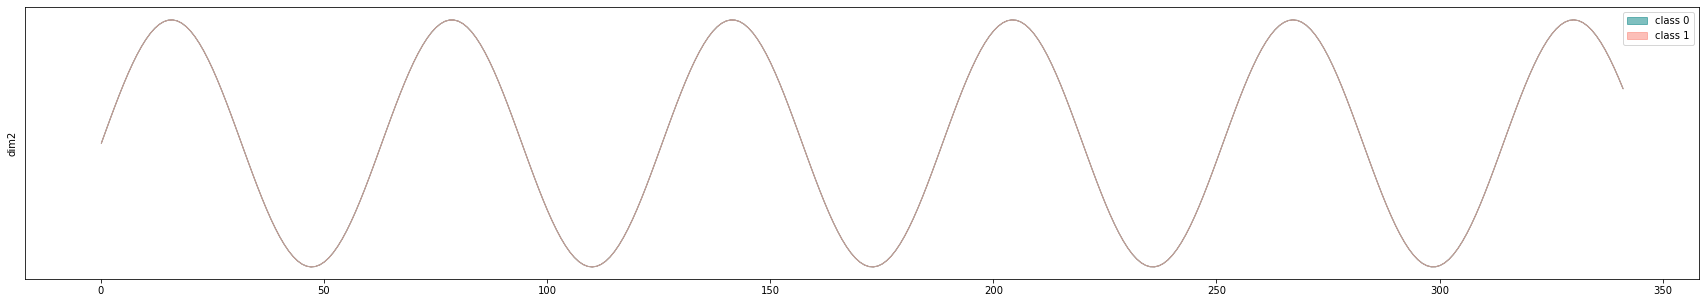

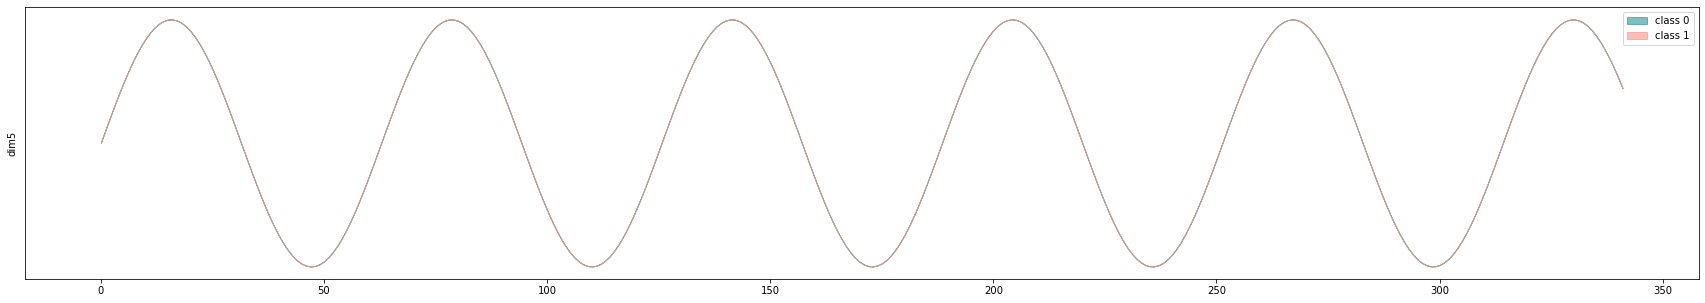

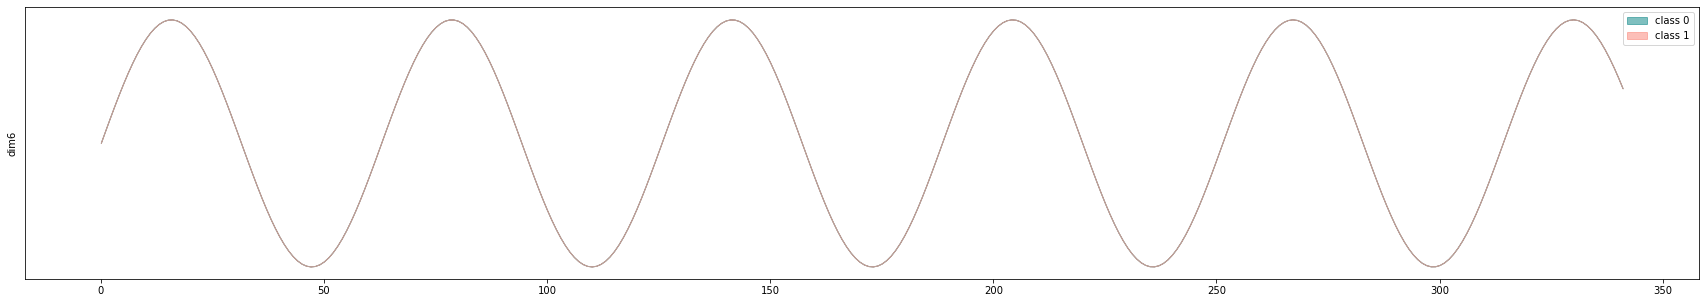

In [17]:
for i in range(len(dimensions_names)):
    plt.figure(figsize=(30,5))
    plt.fill_between(range(len( all_classes_std_mean[i][1])), all_classes_std_mean[i][1]-all_classes_std_mean[i][0], all_classes_std_mean[i][1]+all_classes_std_mean[i][0], alpha=0.5, color='teal')
    plt.fill_between(range(len( all_classes_std_mean[i][1])), all_classes_std_mean_1[i][1]-all_classes_std_mean_1[i][0], all_classes_std_mean_1[i][1]+all_classes_std_mean_1[i][0], alpha=0.5, color='salmon')
    plt.legend(['class 0','class 1'])
    plt.yticks([])
    plt.ylabel(dimensions_names[i])
    plt.show()


In [18]:
np.save('saved_model/'+name+'/all_classes_std_mean_0.npy',all_classes_std_mean)
np.save('saved_model/'+name+'/all_classes_std_mean_1.npy',all_classes_std_mean_1)

### Step 7 (optional): generate sample data for testing the model


In [19]:
print(all_class_shuffled[0].shape)
count = 0
for i in range(len(all_class_shuffled)):
        if y_train[i] == 0:
            for j in range(len(all_class_shuffled[i][0])):
                for k in range(len(all_class_shuffled[i])):
                    with open('./test_'+str(count)+'.csv','a+') as f:
                        if k == len(all_class_shuffled[i])-1:
                            f.write(str(all_class_shuffled[i][k][j])+'\n')
                        else:
                            f.write(str(all_class_shuffled[i][k][j])+',')
                        
            count +=1
        if count > 5:
            
            break
    
    

(8, 342)
